# Exploring large dataset - Cats-vs-Dogs

In [0]:
import os
import zipfile
import random
import math
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

import warnings

warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [0]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-08-23 13:21:32--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.74.20.142, 2600:140e:6:7ac::e59, 2600:140e:6:787::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.74.20.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  12.5MB/s    in 58s     

2019-08-23 13:22:31 (13.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [0]:
try:
#   for path in ['/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/testing/cats', '/tmp/cats-v-dogs/testing/dogs']:
#     for file in os.listdir(path):
#       os.remove(os.path.join(path, file))
#     print(len(os.listdir(path)))
  
  os.makedirs('/tmp/cats-v-dogs/training/cats')
  os.makedirs('/tmp/cats-v-dogs/training/dogs')
  os.makedirs('/tmp/cats-v-dogs/testing/cats')
  os.makedirs('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  list_of_files = os.listdir(SOURCE)
  nbr_of_files = len(list_of_files)
  index = random.sample([x for x in range(nbr_of_files)], nbr_of_files)
  split_limit = math.ceil(nbr_of_files*SPLIT_SIZE)
  train_idx = index[:split_limit]
  test_idx = index[split_limit:]
  
  for idx in train_idx:
    filename = list_of_files[idx]
    path = os.path.join(SOURCE, filename)
    if os.path.getsize(path) == 0:
      print(f'{filename} is zero length, so ignoring')
      continue
    copyfile(path, os.path.join(TRAINING, filename))
    
  for idx in test_idx:
    filename = list_of_files[idx]
    path = os.path.join(SOURCE, filename)
    if os.path.getsize(path) == 0:
      print(f'{filename} is zero length, so ignoring')
      continue
    copyfile(path, os.path.join(TESTING, filename))


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


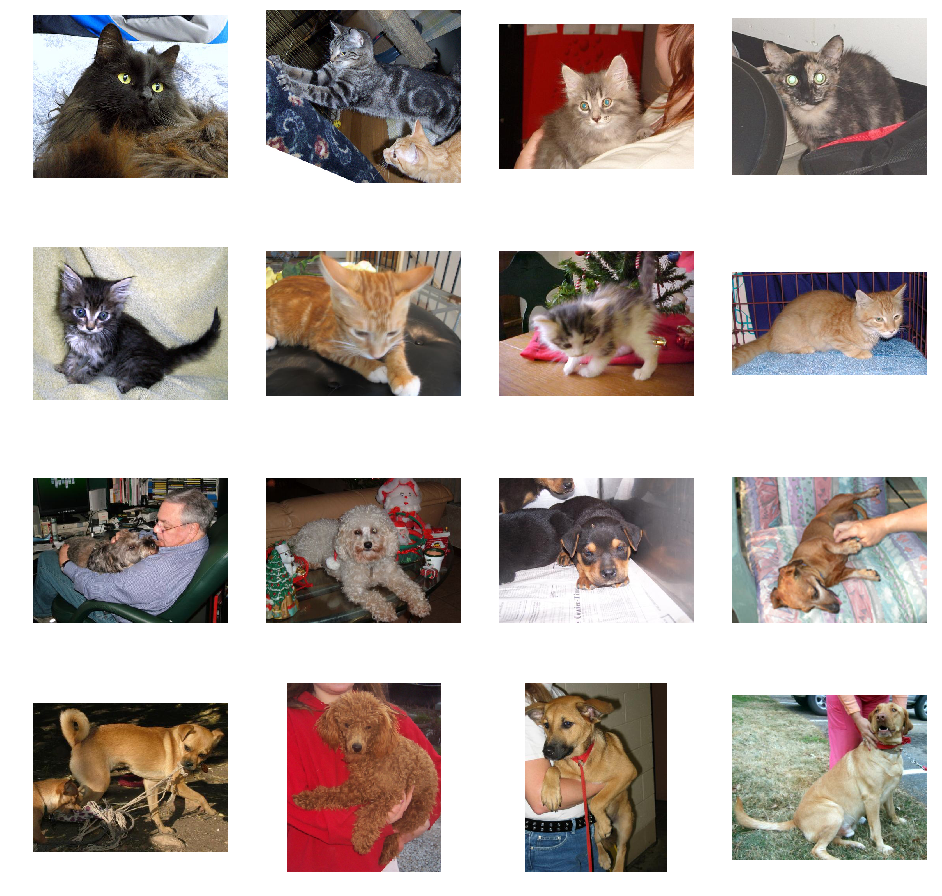

In [0]:
# Now let's take at a few pictures to get better sense of what they look like
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# We'll output images in a 4x4 configuration
n_rows, n_cols = 4, 4
# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(n_rows * 4, n_cols * 4)

train_cat_dir = os.path.join('/tmp/cats-v-dogs/training/cats')
train_dog_dir = os.path.join('/tmp/cats-v-dogs/training/dogs')
train_cat_names = os.listdir(train_cat_dir)
train_dog_names = os.listdir(train_dog_dir)

pic_index += 8
next_cats = [os.path.join(train_cat_dir, fname) for fname in train_cat_names[pic_index-8:pic_index]]
next_dogs = [os.path.join(train_dog_dir, fname) for fname in train_dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cats + next_dogs):
  ax = plt.subplot(n_rows, n_cols, i + 1)
  ax.axis('Off')
  
  img = mpimg.imread(img_path)
  plt.imshow(img)
#   print(f'{img.shape}')
plt.show()

In [0]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                                  TRAINING_DIR,
                                  target_size=(150, 150),
                                  batch_size=100,
                                  class_mode='binary')

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
                                  VALIDATION_DIR,
                                  target_size=(150, 150),
                                  batch_size=100,
                                  class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

W0823 13:29:33.930869 140096039094144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 13:29:34.178745 140096039094144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
  
  def __init__(self):
    tf.keras.callbacks.Callback.__init__(self)
    self._threhold = .2
  
  def on_epoch_end(self, epoch, logs=None):
    
    if logs.get('val_acc') >= .95:
      print('\nReached .95 of val_acc so stopping training')
      self.model.stop_training = True
      self.model.save_weights('m95.h5')
    elif logs.get('val_acc') > .94:
      self.model.save_weights('m94.h5')
    elif logs.get('val_acc') > .93:
      self.model.save_weights('m93.h5')
    elif logs.get('val_acc') > .92:
      self.model.save_weights('m92.h5')
    elif logs.get('val_acc') > .91:
      self.model.save_weights('m91.h5')
    elif logs.get('val_acc') > .90:
      self.model.save_weights('m90.h5')

In [0]:
history = model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              callbacks=[StopTrainingCallback()],
                              validation_data=validation_generator)

Epoch 1/50
225/225 [==============================] - 90s 401ms/step - loss: 0.7511 - acc: 0.6124 - val_loss: 0.6158 - val_acc: 0.6720
Epoch 2/50
225/225 [==============================] - 85s 376ms/step - loss: 0.5378 - acc: 0.7320 - val_loss: 0.4773 - val_acc: 0.7692
Epoch 3/50
225/225 [==============================] - 85s 380ms/step - loss: 0.4565 - acc: 0.7840 - val_loss: 0.5004 - val_acc: 0.7512
Epoch 4/50
225/225 [==============================] - 85s 377ms/step - loss: 0.3874 - acc: 0.8264 - val_loss: 0.4059 - val_acc: 0.8160
Epoch 5/50
225/225 [==============================] - 85s 378ms/step - loss: 0.3276 - acc: 0.8585 - val_loss: 0.4648 - val_acc: 0.7940
Epoch 6/50
225/225 [==============================] - 86s 383ms/step - loss: 0.2557 - acc: 0.8949 - val_loss: 0.4428 - val_acc: 0.8280
Epoch 7/50
225/225 [==============================] - 85s 380ms/step - loss: 0.1847 - acc: 0.9261 - val_loss: 0.6035 - val_acc: 0.8056
Epoch 8/50
225/225 [==============================] - 8

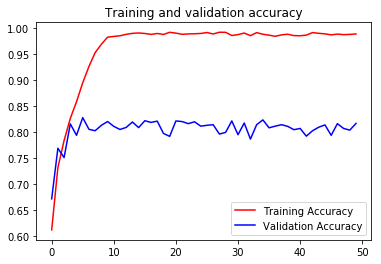

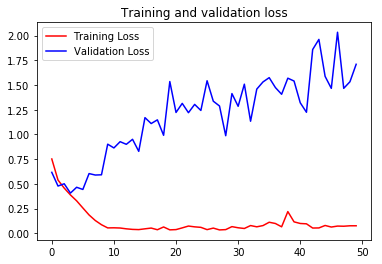

In [0]:
# PLOT LOSS AND ACCURACY
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], color='r', label="Training Accuracy")
plt.plot(history.history['val_acc'], color='b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], color='r', label="Training Loss") # , "Training Loss"
plt.plot(history.history['val_loss'], color='b', label="Validation Loss") # , "Validation Loss"
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
#   predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")